# Gun Violence Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# gun violence data 2013-2018
#df_gun_violence = pd.read_csv('./dataset/gun-violence-data_01-2013_03-2018.csv')
df_gun_violence = pd.read_csv('https://media.githubusercontent.com/media/Cng000/Gun-violence-analysis/gun-violence-data/dataset/gun-violence-data_01-2013_03-2018.csv')

In [3]:
# mean annual household income (2016)
#df_income = pd.read_csv('./dataset/2016_mean_income_raw_data.csv', skiprows=2)
df_income = pd.read_csv('https://raw.githubusercontent.com/Cng000/Gun-violence-analysis/gun-violence-data/dataset/2016_mean_income_raw_data.csv', skiprows=2)

## Gun Violence Analysis

In [4]:
df_gun_violence.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239677 entries, 0 to 239676
Data columns (total 29 columns):
incident_id                    239677 non-null int64
date                           239677 non-null object
state                          239677 non-null object
city_or_county                 239677 non-null object
address                        223180 non-null object
n_killed                       239677 non-null int64
n_injured                      239677 non-null int64
incident_url                   239677 non-null object
source_url                     239209 non-null object
incident_url_fields_missing    239677 non-null bool
congressional_district         227733 non-null float64
gun_stolen                     140179 non-null object
gun_type                       140226 non-null object
incident_characteristics       239351 non-null object
latitude                       231754 non-null float64
location_description           42089 non-null object
longitude                    

In [5]:
df_gun_violence.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0


In [6]:
df_gun_violence_new = df_gun_violence[['incident_id', 'date', 'state', 'city_or_county', 'n_killed', 'n_injured', 'congressional_district', 'gun_stolen', 'gun_type', 'incident_characteristics', 'n_guns_involved', 'participant_age', 'participant_age_group', 'participant_gender', 'participant_status', 'participant_type', 'state_house_district', 'state_senate_district']]

In [7]:
df_gun_violence_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239677 entries, 0 to 239676
Data columns (total 18 columns):
incident_id                 239677 non-null int64
date                        239677 non-null object
state                       239677 non-null object
city_or_county              239677 non-null object
n_killed                    239677 non-null int64
n_injured                   239677 non-null int64
congressional_district      227733 non-null float64
gun_stolen                  140179 non-null object
gun_type                    140226 non-null object
incident_characteristics    239351 non-null object
n_guns_involved             140226 non-null float64
participant_age             147379 non-null object
participant_age_group       197558 non-null object
participant_gender          203315 non-null object
participant_status          212051 non-null object
participant_type            214814 non-null object
state_house_district        200905 non-null float64
state_senate_district 

#### Top 10 cities/counties by number of incidents

In [8]:
df_gun_violence_new['city_or_county'].value_counts().head(10)

Chicago         10814
Baltimore        3943
Washington       3279
New Orleans      3071
Philadelphia     2963
Houston          2501
Saint Louis      2501
Milwaukee        2487
Jacksonville     2448
Memphis          2386
Name: city_or_county, dtype: int64

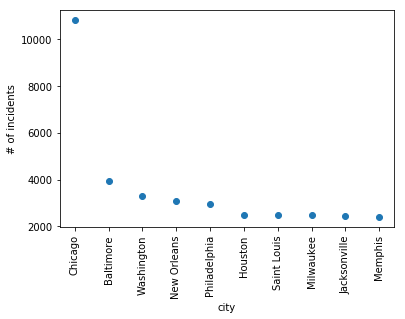

In [9]:
# graph results
y = df_gun_violence_new['city_or_county'].value_counts().index
x = df_gun_violence_new['city_or_county'].value_counts().head(10)
x = list(x)

city = []
for i in range(0,10):
    city.append(y[i])

_ = plt.scatter(x=city, y=x)
_ = plt.xticks(rotation=90)
_ = plt.xlabel("city")
_ = plt.ylabel("# of incidents")
plt.show()

#### Top 10 cities/counties by number of deaths

In [10]:
df_gun_violence_new.groupby('city_or_county')['n_killed'].sum().sort_values(ascending=False).head(10)

city_or_county
Chicago         2104
Houston         1145
Baltimore       1055
Saint Louis      919
Philadelphia     901
New Orleans      703
Los Angeles      636
Memphis          623
Indianapolis     616
Detroit          604
Name: n_killed, dtype: int64

#### Top 10 cities/counties by number of injured

In [11]:
df_gun_violence_new.groupby('city_or_county')['n_injured'].sum().sort_values(ascending=False).head(10)

city_or_county
Chicago         10427
Baltimore        2427
Philadelphia     2326
New Orleans      1892
Saint Louis      1783
Memphis          1690
Milwaukee        1570
Washington       1439
Columbus         1319
Houston          1255
Name: n_injured, dtype: int64

#### Top 10 states with higher number of incidents

In [12]:
df_gun_violence_new['state'].value_counts().head(10)

Illinois          17556
California        16306
Florida           15029
Texas             13577
Ohio              10244
New York           9712
Pennsylvania       8929
Georgia            8925
North Carolina     8739
Louisiana          8103
Name: state, dtype: int64

#### Top 10 states with higher number of deaths

In [13]:
df_gun_violence_new.groupby('state')['n_killed'].sum().sort_values(ascending=False).head(10)

state
California        5562
Texas             5046
Florida           3909
Illinois          3409
Ohio              2508
Georgia           2456
Pennsylvania      2395
North Carolina    2225
Louisiana         2179
Missouri          2136
Name: n_killed, dtype: int64

#### Top 10 states with higher number of injuries

In [14]:
df_gun_violence_new.groupby('state')['n_injured'].sum().sort_values(ascending=False).head(10)

state
Illinois          13514
California         7644
Florida            7072
Texas              6106
Ohio               5703
New York           5059
Pennsylvania       5056
North Carolina     4629
Tennessee          4478
Louisiana          4398
Name: n_injured, dtype: int64

## Mean Income 2016 Analysis

In [15]:
df_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 2 columns):
Location                          57 non-null object
Median Annual Household Income    52 non-null object
dtypes: object(2)
memory usage: 1008.0+ bytes


In [16]:
df_income.head()

,Location,Median Annual Household Income
0,United States,$59039
1,Alabama,$47221
2,Alaska,$75723
3,Arizona,$57100
4,Arkansas,$45907


In [17]:
# dropped US average income and 'Notes'
df_income.drop(df_income.index[0], inplace=True)
df_income.drop(df_income.index[52:], inplace=True)

In [18]:
df_income

,Location,Median Annual Household Income
1,Alabama,$47221
2,Alaska,$75723
3,Arizona,$57100
4,Arkansas,$45907
5,California,$66637
6,Colorado,$70566
7,Connecticut,$75923
8,Delaware,$58046
9,District of Columbia,$70982
10,Florida,$51176


In [19]:
# renamed columns
# dropped '$' and convert from str to int
df_income = df_income.rename(index=str, columns={"Location":"state", "Median Annual Household Income": "median_annual_household_income_2016"})
df_income['median_annual_household_income_2016'] = pd.to_numeric(df_income['median_annual_household_income_2016'].str[1:], downcast='integer')
df_income

,state,median_annual_household_income_2016
1,Alabama,47221.0
2,Alaska,75723.0
3,Arizona,57100.0
4,Arkansas,45907.0
5,California,66637.0
6,Colorado,70566.0
7,Connecticut,75923.0
8,Delaware,58046.0
9,District of Columbia,70982.0
10,Florida,51176.0


In [20]:
# merged both dataframe(gun-violence && 2016_income)
df_gun_income = pd.merge(df_gun_violence_new, df_income, on="state", how="outer")
df_gun_income

,incident_id,date,state,city_or_county,n_killed,n_injured,congressional_district,gun_stolen,gun_type,incident_characteristics,n_guns_involved,participant_age,participant_age_group,participant_gender,participant_status,participant_type,state_house_district,state_senate_district,median_annual_household_income_2016
0,461105.0,2013-01-01,Pennsylvania,Mckeesport,0.0,4.0,14.0,NaN,NaN,Shot - Wounded/Injured||Mass Shooting (4+ vict...,NaN,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,NaN,NaN,60979.0
1,484268.0,2013-04-09,Pennsylvania,Philadelphia,1.0,3.0,1.0,NaN,NaN,"Shot - Wounded/Injured||Shot - Dead (murder, a...",NaN,0::21||1::18||2::22||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male||4::Male,0::Killed||1::Injured||2::Injured||3::Injured|...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,NaN,NaN,60979.0
2,485885.0,2013-04-28,Pennsylvania,Chester,1.0,3.0,1.0,0::Unknown||1::Unknown,0::Unknown||1::Unknown,"Shot - Wounded/Injured||Shot - Dead (murder, a...",2.0,0::17||1::16||2::18||3::40,0::Teen 12-17||1::Teen 12-17||2::Adult 18+||3:...,0::Male||1::Male||3::Male||4::Male||5::Male||6...,0::Killed||1::Injured||2::Injured||3::Injured|...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,NaN,NaN,60979.0
3,486068.0,2013-05-06,Pennsylvania,Johnstown,0.0,4.0,12.0,NaN,NaN,Shot - Wounded/Injured||Mass Shooting (4+ vict...,NaN,NaN,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male,0::Injured||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim,NaN,NaN,60979.0
4,486121.0,2013-05-11,Pennsylvania,Philadelphia,0.0,4.0,2.0,NaN,NaN,Shot - Wounded/Injured||Drive-by (car to stree...,NaN,0::15||1::16||2::17||3::20,0::Teen 12-17||1::Teen 12-17||2::Teen 12-17||3...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Injured||1::Injured||2::Injured||3::Injured...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,NaN,NaN,60979.0
5,486334.0,2013-05-16,Pennsylvania,Philadelphia,0.0,4.0,1.0,0::Unknown,0::44 Mag,Shot - Wounded/Injured||Mass Shooting (4+ vict...,1.0,0::41||1::21||2::26,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Female||3::Male||4::Male|...,0::Injured||1::Injured||2::Injured||3::Injured...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,NaN,NaN,60979.0
6,487645.0,2013-06-09,Pennsylvania,York,0.0,4.0,4.0,NaN,NaN,Shot - Wounded/Injured||Mass Shooting (4+ vict...,NaN,NaN,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::T...,0::Male||1::Male||2::Male||3::Female,0::Injured||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim,NaN,NaN,60979.0
7,964573.0,2013-08-05,Pennsylvania,Philadelphia,1.0,0.0,2.0,0::Unknown,0::Unknown,"Shot - Dead (murder, accidental, suicide)||Gan...",1.0,1::30,0::Adult 18+||1::Adult 18+,0::Male||1::Male,0::Killed||1::Arrested,0::Victim||1::Subject-Suspect,190.0,7.0,60979.0
8,491609.0,2013-08-06,Pennsylvania,Saylorsburg,3.0,4.0,17.0,0::Unknown||1::Unknown,0::223 Rem [AR-15]||1::44 Mag,"Shot - Wounded/Injured||Shot - Dead (murder, a...",2.0,0::62||1::53||2::64||6::59,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male||5...,0::Killed||1::Killed||2::Killed||3::Injured||4...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,NaN,NaN,60979.0
9,491770.0,2013-08-13,Pennsylvania,Philadelphia,0.0,4.0,2.0,NaN,NaN,Shot - Wounded/Injured||Mass Shooting (4+ vict...,NaN,NaN,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male,0::Injured||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim,NaN,NaN,60979.0


In [21]:
# merge incident count and mean income (mean annual income household 2016 only) per state
incident_count_per_state = df_gun_income['state'].value_counts().to_frame().reset_index().rename(index=str, columns={"index":"state", "state":"incident_count"})
state_incidentCount_medianIncome = pd.merge(incident_count_per_state, df_income, on="state", how="outer")
state_incidentCount_medianIncome


,state,incident_count,median_annual_household_income_2016
0,Illinois,17556,61386.0
1,California,16306,66637.0
2,Florida,15029,51176.0
3,Texas,13577,58146.0
4,Ohio,10244,53985.0
5,New York,9712,61437.0
6,Pennsylvania,8929,60979.0
7,Georgia,8925,53527.0
8,North Carolina,8739,53764.0
9,Louisiana,8103,42196.0


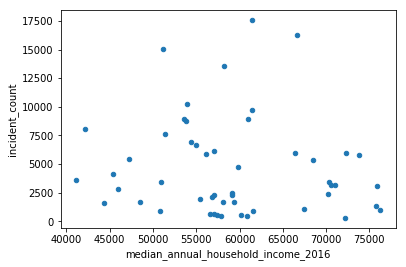

In [22]:
# graphed (median_income && incident_count)
state_incidentCount_medianIncome.plot.scatter('median_annual_household_income_2016', 'incident_count')